<a href="https://colab.research.google.com/github/078shashank/-HamperNests/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [4]:
# 3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generators with only rescaling (augmentation will come later in Cell 5)
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Training data
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Validation data
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=batch_size,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Test data — fix: test has no subfolders, so use "classes=['test']"
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    classes=['test'],       # explicitly look inside the "test" folder
    batch_size=batch_size,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


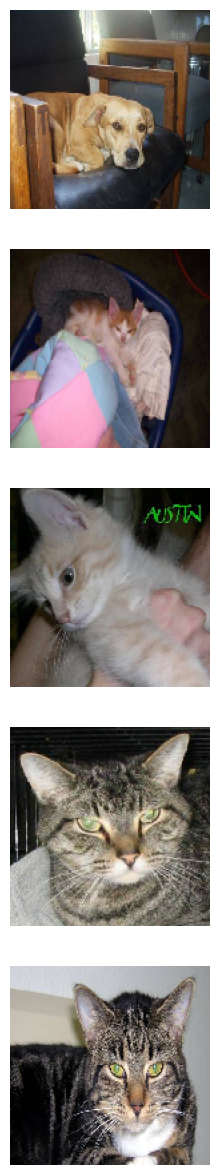

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Found 2000 images belonging to 2 classes.


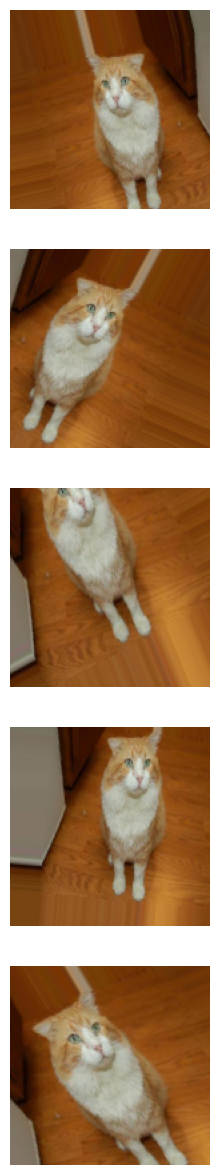

In [6]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Re-create train_data_gen with augmentation
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Preview some augmented images
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


Found 2000 images belonging to 2 classes.


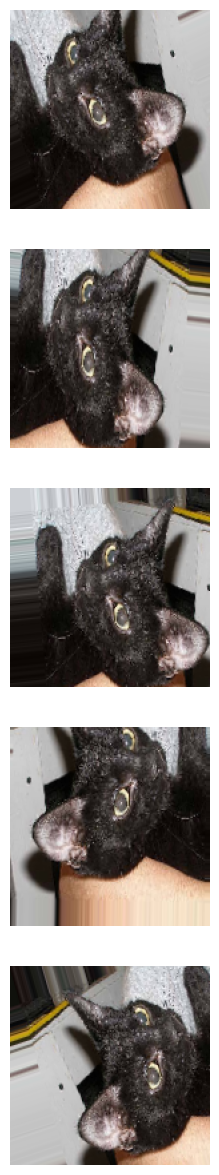

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
# 7
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=35,   # increase for better results
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4733 - loss: 0.7359 - val_accuracy: 0.5033 - val_loss: 0.6925
Epoch 2/35
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5078 - loss: 0.6932

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5078 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.6965
Epoch 3/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5123 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6956
Epoch 4/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5234 - loss: 0.6898 - val_accuracy: 0.5045 - val_loss: 0.6948
Epoch 5/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 911ms/step - accuracy: 0.5182 - loss: 0.6933 - val_accuracy: 0.5826 - val_loss: 0.6662
Epoch 6/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5859 - loss: 0.6735 - val_accuracy: 0.5714 - val_loss: 0.6651
Epoch 7/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 911ms/step - accuracy: 0.5875 - loss: 0.6762 - val_accuracy: 0.6239 - val_loss: 0.6712
Epoch 8/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.5703 - loss: 0.6780 - val_accuracy: 0.6406 - val_loss: 0.6705
Epoch 9/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step - accuracy: 0.5929 - loss: 0.6760 - val_accuracy: 0.5826 - val

ValueError: x and y must have same first dimension, but have shapes (15,) and (35,)

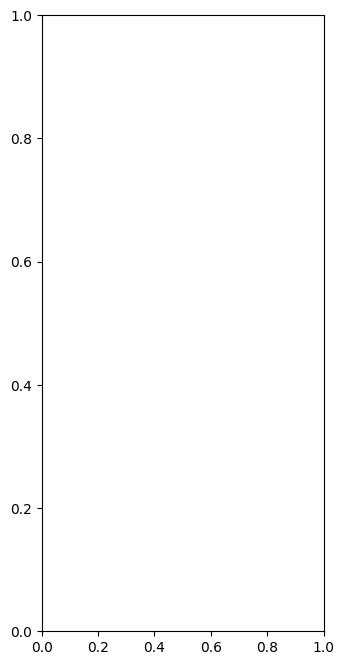

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 10
# Get predictions on the test set
probabilities = model.predict(test_data_gen)

# Flatten to a 1D list for easier comparison
probabilities = probabilities.flatten()

# Show the first few predictions
print("First 10 probabilities:", probabilities[:10])

# Optional: visualize test predictions
sample_test_images, _ = next(test_data_gen)
plotImages(sample_test_images[:5], probabilities[:5])


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")